# Varational autoencoder by RNN for sudoku sequence generation

## dataset 
- [10,000 solved sudoku](http://www.printable-sudoku-puzzles.com/wfiles/)
- [bigger dataset: 1M sudoku and solutions](https://www.kaggle.com/bryanpark/sudoku)

## Load sudoku training data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from glob import glob

import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

## Data Processing

In [3]:
symbol2index = dict(zip('123456789', range(9)))
index2symbol = dict(zip(range(9), '123456789'))

def puzzle2tensor(puzzle_batch):
    batch_size = len(puzzle_batch)
    seq_len = len(puzzle_batch[0])
    t = torch.zeros([batch_size, seq_len, 9])
    for r in range(batch_size):
        for c in range(seq_len):
            s = symbol2index[puzzle_batch[r][c]]
            t[r, c, s] = 1
    return t

def puzzle2target(puzzle_batch):
    batch_size = len(puzzle_batch)
    seq_len = len(puzzle_batch[0])
    t = torch.LongTensor(batch_size, seq_len).zero_()
    for r in range(batch_size):
        for c in range(seq_len):
            s = symbol2index[puzzle_batch[r][c]]
            t[r, c] = s
    return t

def tensor2puzzle(tensors):
    """tensors.size() == [batch_size, seq, 9]
    """
    _, p = tensors.max(dim=2)
    p = p.squeeze().numpy()
    puzzles = []
    for r in p:
        puzzles.append(''.join([index2symbol.get(s) for s in r]))
    return puzzles

def output2puzzle(y):
    """y.size() == [batch_size, 9]
    """
    _, labels = y.max(dim=1)
    return labels.numpy().squeeze() + 1

## build a sudoku env following openai

In [4]:
class Sudoku(object):
    
    def __init__(self):
        self.state = None
        
    def reset(self):
        """return observation"""
        self.state = []
        obs = ''.join(self.state)
        return obs
    
    def step(self, action):
        """action: '123456789'
        return [obs, reward, done, info]"""
        self.state.append(action)
        obs = ''.join(self.state)
        reward = 1
        valid, info = self.is_valid(self.state)
        done = not valid
        return [obs, reward, done, info]
    
    def is_valid(self, puzzle):
        """puzzle: an array of digits.
        Check if a partial puzzle is valid
        """
        nrows = int(np.ceil(len(puzzle)/9))
        for r in range(0, nrows):
            row = puzzle[r*9:(r+1)*9]
            if len(row) != len(set(row)):
                return False, "row rule"
        for c in range(0, 9):
            col = puzzle[c:c+9*9:9]
            if len(col) != len(set(col)):
                return False, "col rule"
        strides = [list(range(0, 3)), list(range(3, 6)), list(range(6, 9))]
        squares = [(r, c) for r in strides for c in strides]
        for sqr, sqc in squares:
            sqi = [r*9+c for r in sqr for c in sqc]
            square = [puzzle[i] for i in sqi if i < len(puzzle)]
            if len(square) != len(set(square)):
                return False, "sqr rule"
        return True, "valid"

In [5]:
env = Sudoku()
print(env.reset())
env.step('1')

['1', 1, False, 'valid']

In [6]:
puzzle = list("123456789987654321")
print(env.is_valid(puzzle))
puzzle = list("123456")
print(env.is_valid(puzzle[:-5]))

(False, 'col rule')
(True, 'valid')


## baseline - random generator policy

In [7]:
def random_policy():
    return np.random.choice( list("123456789"), 1)[0] 

In [8]:
all_rewards = []

env = Sudoku()

for game in range(5000):
    obs = env.reset()
    game_reward = 0
    for _ in range(81):
        action = random_policy()
        obs, reward, done, info = env.step(action)
        game_reward += reward
        if done: break
    all_rewards.append(game_reward)

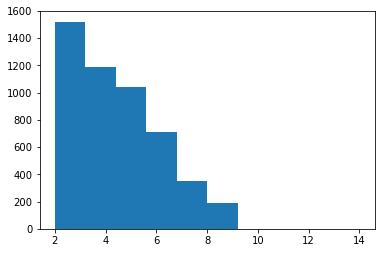

In [9]:
_ = plt.hist(all_rewards)

## rnn model

In [10]:
class SudokuPolicy(nn.Module):
    def __init__(self):
        super(SudokuPolicy, self).__init__()
        self.rnn = nn.GRU(input_size=9, hidden_size=128,
                          num_layers=1, bidirectional=False,
                          batch_first=True)
        self.fc1 = nn.Linear(128, 64)
        self.elu = nn.ELU()
        self.d = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 9)
        self.softmax = nn.Softmax()
    def forward(self, obs):
        batch_size, seq_len, input_size = obs.size()
        h0 = Variable(torch.zeros(1, batch_size, 128)).cuda()
        out, _ = self.rnn(obs, h0)
        out = out[:, -1, :]
        out = self.elu(self.fc1(out))
        out = self.d(out)
        out = self.elu(self.fc2(out))
        out = self.d(out)
        logits = self.fc3(out)
        # probs and labels for action calculation
        probs = self.softmax(logits)
        self.label = torch.multinomial(probs, 1)
        return logits

In [11]:
actions = "123456789"

m = SudokuPolicy().cuda()
obs = Variable(puzzle2tensor(["12"])).cuda()
print( m(obs) )
print( actions[m.label.data.cpu().numpy()[0][0]] )

Variable containing:
-0.0799 -0.1496 -0.1107  0.0558  0.0498  0.0982  0.1732  0.0830 -0.1403
[torch.cuda.FloatTensor of size 1x9 (GPU 0)]

9


## credit assignment

In [12]:
def discount_rewards(rewards, discount_rate):
    """rewards: rewards of all steps for a single game, a list
    """
    discounted_rewards = np.empty(len(rewards),dtype=np.float32)
    accum_reward = 0
    for i in reversed(range(len(rewards))):
        accum_reward = rewards[i] + accum_reward * discount_rate
        discounted_rewards[i] = accum_reward
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    """
    all_rewards: rewards of all games for all steps, a list of list
    """
    discounted_all_rewards = [discount_rewards(rewards, discount_rate)
                             for rewards in all_rewards]
    flatten_rewards = [reward for rewards in discounted_all_rewards
                          for reward in rewards]
    reward_mean = np.mean(flatten_rewards)
    reward_std = np.std(flatten_rewards)
    normalized_rewards = [(rewards - reward_mean) / reward_std
                         for rewards in discounted_all_rewards]
    return normalized_rewards

In [13]:
discount_rewards([10, 0, -50], discount_rate=.8)

array([-22., -40., -50.], dtype=float32)

In [14]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]],
                               discount_rate=0.8)

[array([-0.28435072, -0.86597717, -1.18910301], dtype=float32),
 array([ 1.2666533 ,  1.07277775], dtype=float32)]

## training by policy gradient

In [15]:
objective = nn.CrossEntropyLoss()

model = SudokuPolicy().cuda()
model.train()

SudokuPolicy (
  (rnn): GRU(9, 128, batch_first=True)
  (fc1): Linear (128 -> 64)
  (elu): ELU (alpha=1.0)
  (d): Dropout (p = 0.5)
  (fc2): Linear (64 -> 64)
  (fc3): Linear (64 -> 9)
  (softmax): Softmax ()
)

In [ ]:
%%time

n_epochs = 600
n_max_steps = 81
n_games_per_update = 100
discount_rate = .95




optimizer = optim.Adam(model.parameters(), lr=1e-2)
actions = "123456789"


for epoch in range(n_epochs):
    
    all_losses = []
    all_rewards = []
    
    for game in range(n_games_per_update):
        
        game_losses = []
        game_rewards = []
        
        obs = env.reset()
        first_action = random_policy() # random first action
        obs, reward, done, info = env.step(first_action)
        
        for step in range(n_max_steps):
            # train on one observation
            obs_var = Variable(puzzle2tensor([obs])).cuda()
            model.zero_grad()
            logits = model(obs_var)
            label = model.label.data.cpu().numpy()[0][0]
            action = actions[label]
            obs, reward, done, info = env.step(action)

            y = Variable(torch.LongTensor([int(label)])).cuda()
            loss = objective(logits, y)
            game_losses.append(loss)
            game_rewards.append(reward)
            if done:
                break
                
        all_losses.append(game_losses)
        all_rewards.append(game_rewards)
    
    ## normalize and discount rewards
    normalized_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
    ## aggregate losses
    weighted_loss = np.mean([all_losses[game][step] * float(normalized_rewards[game][step])
                        for game in range(len(normalized_rewards))
                        for step in range(len(normalized_rewards[game]))])
    model.zero_grad()
    weighted_loss.backward()
    ## optimize based on aggregated gradient
    optimizer.step()
    if epoch % 25 == 0:
        rewards = [np.sum(reward) for reward in all_rewards]
        mean_reward = np.mean(rewards)
        max_reward = np.max(rewards)
        print(epoch, mean_reward, max_reward)

0 3.71 8
25 4.58 8
50 6.0 11
75 6.48 13
100 7.11 14
125 7.97 16
150 9.05 16
175 8.59 13
200 9.09 16
225 10.12 16
250 8.21 18
275 9.47 18
300 9.69 18
325 10.03 18
350 10.87 18
375 10.78 18
400 11.22 18
425 10.29 18
450 11.02 18
